# Posthoc Classifier

## Install, Paths and Parameters

In [1]:
# This extension reloads external Python files
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import math
import torch
from torch import nn
from tqdm import tqdm
import random
import sys
from torch.utils.data import random_split
from matplotlib import pyplot as plt

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino
from src.model.data import create_loader, adv_dataset, ORIGINAL_TRANSFORM, NO_NORM_TRANSFORM, TO_TENSOR_TRANSFORM

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')
# Path for intermediate outputs
BASE_POSTHOC_PATH = Path(DATA_PATH, 'posthoc/')

# Original Dataset
ORI_PATH = Path(DATA_PATH, 'ori_data/validation/')
ORI_LABEL_PATH = Path(ORI_PATH,'correct_labels.txt')
ORI_IMAGES_PATH = Path(ORI_PATH,'images')

# DAmageNet
DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')
DN_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'damagenet')
DN_POSTHOC_LABEL_PATH = Path(DN_POSTHOC_PATH, 'labels.csv')

# PGD
PGD_PATH = Path(DATA_PATH, 'adversarial_data/pgd_03/validation')
PGD_LABEL_PATH = ORI_LABEL_PATH
PGD_IMAGES_PATH = Path(PGD_PATH, 'images')
PGD_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'pgd')
PGD_POSTHOC_LABEL_PATH = Path(PGD_POSTHOC_PATH, 'labels.csv')

# CW
CW_PATH = Path(DATA_PATH, 'adversarial_data/cw/validation')
CW_LABEL_PATH = ORI_LABEL_PATH
CW_IMAGES_PATH = Path(CW_PATH, 'images')
CW_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'cw')
CW_POSTHOC_LABEL_PATH = Path(CW_POSTHOC_PATH, 'labels.csv')

In [2]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
INDEX_SUBSET = get_random_indexes()
CLASS_SUBSET = get_random_classes()
INDEX_SUBSET = None
CLASS_SUBSET = None

BATCH_SIZE = 1

DEVICE = 'cuda'

In [3]:
#!python $HOME/deeplearning/setup/collect_env.py

## Import DINO
Official repo: https://github.com/facebookresearch/dino

In [4]:
model, linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights.


## Dataloaders

In [5]:
ori_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE, transform=NO_NORM_TRANSFORM)

In [6]:
dn_loader = create_loader(DN_IMAGES_PATH, DN_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE, transform=NO_NORM_TRANSFORM)
pgd_loader = create_loader(PGD_IMAGES_PATH, PGD_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE, transform=TO_TENSOR_TRANSFORM)
cw_loader = create_loader(CW_IMAGES_PATH, CW_LABEL_PATH, INDEX_SUBSET, CLASS_SUBSET, BATCH_SIZE, transform=TO_TENSOR_TRANSFORM)

## Adversarial Sample Tuples

### Iterator

In [7]:
# Performs a forward pass given a sample `inp` and a classifier.
def generate_model_output(inp, n=4):
    inp = inp.to("cuda")
    # add one dimension to input image (get_intermediate_layers expects it)
    inp = inp.unsqueeze(dim=0)
    intermediate_output = model.get_intermediate_layers(inp, n)
    return torch.cat([x[:, 0] for x in intermediate_output], dim=-1)

In [8]:
class AdvTupleIterator:
    def __init__(self, ori_loader, adv_loader, model, linear_classifier, max=0, visualize=False):
        self.samples = adv_dataset(ori_loader, adv_loader, model, linear_classifier)
        self.max = max
        self.num = 0
        self.visualize = visualize
    
    def __iter__(self):
        self.num = 0
        return self
        
    def __next__(self):
        if(self.max > 0 and self.num >= self.max):
            raise StopIteration
        self.num += 1
        # payload can be original or adversarial.
        sample, payload, label = next(self.samples)
        if self.visualize:
            img = payload.permute(1, 2, 0)
            plt.imshow(img.cpu(), interpolation='nearest')
            plt.show()
        payload_out = generate_model_output(payload)
        if self.visualize:
            print(f"shape of image: {img.shape}")
            print(f"shape of model output: {payload_out.shape}")
        return sample, payload_out, label

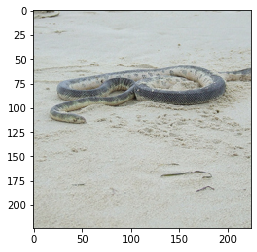

shape of image: torch.Size([224, 224, 3])
shape of model output: torch.Size([1, 1536])
payload 1/2 (label 0)

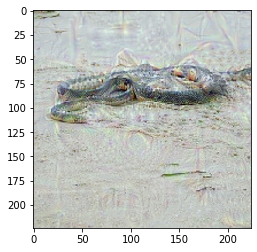

shape of image: torch.Size([224, 224, 3])
shape of model output: torch.Size([1, 1536])
payload 2/2 (label 1)

In [9]:
# testing iterator
adv_loader = dn_loader

total=2
samples = AdvTupleIterator(ori_loader, adv_loader, model, linear_classifier, visualize=True)

for i in range(total):
  num, payload, label = next(samples)
  sys.stdout.write(f"\rpayload {i+1}/{total} (label {label})")
  sys.stdout.flush()

### Saving to disk (once per dataset)

In [18]:
# save to disk!
limit = 1000
datasets = [
    {"posthoc_path": DN_POSTHOC_PATH,  "label_path": DN_POSTHOC_LABEL_PATH},
    {"posthoc_path": PGD_POSTHOC_PATH, "label_path": PGD_POSTHOC_LABEL_PATH},
    {"posthoc_path": CW_POSTHOC_PATH,  "label_path": CW_POSTHOC_LABEL_PATH},
]

for dataset in datasets:
    posthoc_path = dataset["posthoc_path"]
    label_path = dataset["label_path"]

    print(f"posthoc path: {posthoc_path}")
    print(f"label path: {label_path}")

    iterator = AdvTupleIterator(ori_loader, adv_loader, model, linear_classifier, max=0)
    names = []
    paths = []
    labels = []

    for i, (name, payload, label) in enumerate(iterator):
        if limit > 0 and i >= limit: break
        sys.stdout.write(f"\r {i+1}/{limit} {name} (label {label})")
        sys.stdout.flush()
        # original: 0, adversarial: 1
        if label == 0:
            path = f"org/{name}"
        else:
            path = f"adv/{name}"
        paths.append(path)
        names.append(name)
        labels.append(label)
        path = Path(posthoc_path, path)
        torch.save(payload, path)

    df = pd.DataFrame(data={"path": paths, "name": names, "label": labels})
    df.to_csv(label_path, index=False)
    print("")

posthoc path: /cluster/scratch/thobauma/dl_data/posthoc/damagenet
label path: /cluster/scratch/thobauma/dl_data/posthoc/damagenet/labels.csv
 1000/1000 ILSVRC2012_val_00001020 (label 1)
posthoc path: /cluster/scratch/thobauma/dl_data/posthoc/pgd
label path: /cluster/scratch/thobauma/dl_data/posthoc/pgd/labels.csv
 1000/1000 ILSVRC2012_val_00001020 (label 1)
posthoc path: /cluster/scratch/thobauma/dl_data/posthoc/cw
label path: /cluster/scratch/thobauma/dl_data/posthoc/cw/labels.csv
 1000/1000 ILSVRC2012_val_00001020 (label 1)


### Custom dataset for reading from disk

In [19]:
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, index_df):
        super().__init__()
        self.img_folder = img_folder
        self.index_df = index_df
    
    def __len__(self):
        return len(self.index_df)
    
    def __getitem__(self, index):
        filename = self.index_df['path'].iloc[index]
        label = self.index_df['label'].iloc[index]
        payload = torch.load(Path(self.img_folder, filename))
        return filename, payload, label

## Posthoc Classifier

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [21]:
# Simple Binary Classifier Network
class SimpleBC(nn.Module):
    def __init__(self, input_shape):
        super(SimpleBC,self).__init__()
        self.fc1 = nn.Linear(input_shape,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [22]:
# Linear Binary Classifier
class LinearBC(nn.Module):
    def __init__(self, input_shape):
        super(LinearBC,self).__init__()
        self.fc1 = nn.Linear(input_shape,1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

In [23]:
from tqdm import tqdm

# Hyperparameters
EPOCHS = 10

# Initialise network
net = LinearBC(1536)

# Select device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net.to(device)

# Set model to train
net.train()

# define loss, optimizer, and scheduler
criterion = nn.BCELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=1e-08, weight_decay=0)
# scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

losses = []
accur = []

train_files = []
test_files = []

def train(posthoc_path, posthoc_label_path):
    index_df = pd.read_csv(posthoc_label_path)
    train_len = math.floor(len(index_df) * 0.7)
    test_len = len(index_df) - train_len

    train_dataset, test_dataset = random_split(AdvDataset(posthoc_path, index_df), [train_len, test_len], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)
    
    # Train network
    pbar = tqdm(range(EPOCHS))
    for epoch in pbar:  # loop over the dataset multiple times

        # Metrics
        train_running_loss = 0.0
        train_running_loss_mean = 0.0
        train_acc = 0.0
        train_acc_mean = 0.0
        test_running_loss = 0.0
        test_acc = 0.0

        for i, (filename, inputs, labels) in enumerate(train_loader, start=0):        
            train_files.append(filename)
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward Pass
            outputs = net(inputs).float()
            outputs = outputs.reshape(-1)

            # Backpropagation
            optimizer.zero_grad() # Reset the gradient
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # loss train
            train_running_loss += loss.item()
            train_running_loss_mean = train_running_loss / (i+1)

            # accuracy train
            predicted = net(inputs).reshape(-1).detach().cpu().numpy().round()
            acc_labels = labels
            acc_labels = acc_labels.detach().cpu().numpy()
            inter = np.equal(predicted, acc_labels)
            train_acc += inter.sum()
            #train_acc_mean = train_acc / (i+1)

        with torch.no_grad():
            for filename, inputs, labels in test_loader:
                test_files.append(filename)
                try:
                    # get the inputs; data is a list of [inputs, labels] and write to device
                    inputs = inputs.to(device)
                    labels = labels.to(device).float()

                    # Forward Pass
                    outputs = net(inputs).float()
                    outputs = outputs.reshape(-1)

                    # loss test
                    loss = criterion(outputs, labels)
                    test_running_loss += loss.item()

                    # accuracy test
                    outputs = outputs.detach().cpu().numpy().round()
                    comparison = np.equal(labels.detach().cpu().numpy(), outputs)
                    test_acc += comparison.sum()

                except Exception as e:
                    print("Error: {}".format(e))
                    pass

        losses.append(train_running_loss_mean)
        accur.append(train_acc_mean)
        pbar.set_description("Ep: {}\t Tr. Loss: {:.4f}\t Tr. Acc: {:.4f}\t T. Loss: {:.4f}\t T. Acc: {:.4f}".format(epoch, 
                                                                                train_running_loss_mean, 
                                                                                train_acc / len(train_loader.dataset), 
                                                                                test_running_loss, 
                                                                                test_acc / len(test_loader.dataset)))

    print('Finished Training')

print("DAmageNet:")
train(DN_POSTHOC_PATH, DN_POSTHOC_LABEL_PATH)
print("PGD:")
train(PGD_POSTHOC_PATH, PGD_POSTHOC_LABEL_PATH)
print("CW:")
train(CW_POSTHOC_PATH, CW_POSTHOC_LABEL_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

DAmageNet:


Ep: 9	 Tr. Loss: 0.0011	 Tr. Acc: 1.0000	 T. Loss: 1.9946	 T. Acc: 0.9733: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Finished Training
PGD:


Ep: 9	 Tr. Loss: 0.0007	 Tr. Acc: 1.0000	 T. Loss: 1.8514	 T. Acc: 0.9733: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Finished Training
CW:


Ep: 9	 Tr. Loss: 0.0005	 Tr. Acc: 1.0000	 T. Loss: 1.7752	 T. Acc: 0.9767: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

Finished Training
